In [ ]:
#| default_exp processing.coordinates

# Coordinate transformations for vector data

> Adapted from https://solaris.readthedocs.io/en/latest/_modules/solaris/vector/polygon.html

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from drone_detector.imports import *
from drone_detector.utils import *
from shapely.geometry import mapping

In [ ]:
#| export

def _reduce_geom_precision(geom, precision=2):
    "Grom solaris.utils.geo"
    geojson = mapping(geom)
    geojson['coordinates'] = np.round(np.array(geojson['coordinates']),
                                      precision)
    return shape(geojson)


def convert_poly_coords(geom:shape, raster_src:str=None, affine_obj:affine.Affine=None,
                        inverse:bool=False, precision=None) -> shape:
    "Adapted from solaris. Converts georeferenced coordinates to pixel coordinates and vice versa"
    if not raster_src and not affine_obj:
        raise ValueError("Either raster_src or affine_obj must be provided.")

    if raster_src is not None:
        affine_xform = get_geo_transform(raster_src)
    else:
        if isinstance(affine_obj, affine.Affine):
            affine_xform = affine_obj
        else:
            # assume it's a list in either gdal or "standard" order
            # (list_to_affine checks which it is)
            if len(affine_obj) == 9:  # if it's straight from rasterio
                affine_obj = affine_obj[0:6]
            affine_xform = list_to_affine(affine_obj)

    if inverse:  # geo->px transform
        affine_xform = ~affine_xform

    if isinstance(geom, str):
        # get the polygon out of the wkt string
        g = shapely.wkt.loads(geom)
    elif isinstance(geom, shapely.geometry.base.BaseGeometry):
        g = geom
    else:
        raise TypeError('The provided geometry is not an accepted format. '
                        'This function can only accept WKT strings and '
                        'shapely geometries.')

    xformed_g = shapely.affinity.affine_transform(g, [affine_xform.a,
                                                      affine_xform.b,
                                                      affine_xform.d,
                                                      affine_xform.e,
                                                      affine_xform.xoff,
                                                      affine_xform.yoff])
    if isinstance(geom, str):
        # restore to wkt string format
        xformed_g = shapely.wkt.dumps(xformed_g)
    if precision is not None:
        xformed_g = _reduce_geom_precision(xformed_g, precision=precision)

    return xformed_g    

def affine_transform_gdf(gdf:gpd.GeoDataFrame, affine_obj:affine.Affine, inverse:bool=False, 
                         geom_col:str='geometry', precision:int=None) -> gpd.GeoDataFrame:
    """Adapted from solaris, transforms all geometries in GeoDataFrame to pixel coordinates from
    Georeferced coordinates and vice versa"""
    if 'geometry' not in gdf.columns: gdf = gdf.rename(columns={geom_col: 'geometry'})
    gdf["geometry"] = gdf["geometry"].apply(convert_poly_coords,
                                            affine_obj=affine_obj,
                                            inverse=inverse)
    if precision is not None:
        gdf['geometry'] = gdf['geometry'].apply(
            _reduce_geom_precision, precision=precision)

    # the CRS is no longer valid - remove it
    gdf.crs = None

    return gdf


def gdf_to_px(gdf:gpd.GeoDataFrame, im_path, geom_col:str='geometry', precision:int=None,
              outpath=None, override_crs=False) -> gpd.GeoDataFrame:
    "Adapted from https://solaris.readthedocs.io/en/latest/_modules/solaris/vector/polygon.html#geojson_to_px_gdf"
    
    with rio.open(im_path) as im:
        affine_obj = im.transform
    
    transformed_gdf = affine_transform_gdf(gdf, affine_obj=affine_obj,
                                           inverse=True, precision=precision,
                                           geom_col=geom_col)
    
    transformed_gdf['image_fname'] = os.path.split(im_path)[1]

    if outpath is not None:
        if outpath.lower().endswith('json'):
            transformed_gdf.to_file(outpath, driver='GeoJSON')
        else:
            transformed_gdf.to_csv(outpath, index=False)
    return transformed_gdf

def georegister_px_df(df:pd.DataFrame, im_path=None, affine_obj:affine.Affine=None, crs=None,
                      geom_col:str='geometry', precision:int=None, output_path=None) -> gpd.GeoDataFrame:
    with rio.open(im_path) as im:
        affine_obj = im.transform
        crs = im.crs
    
    tmp_df = affine_transform_gdf(df, affine_obj, geom_col=geom_col,
                                  precision=precision)
    result = gpd.GeoDataFrame(tmp_df)
    result.set_crs(crs='epsg:' + str(crs.to_epsg()), allow_override=True, inplace=True)

    if output_path is not None:
        if output_path.lower().endswith('json'):
            result.to_file(output_path, driver='GeoJSON')
        else:
            result.to_csv(output_path, index=False)

    return result

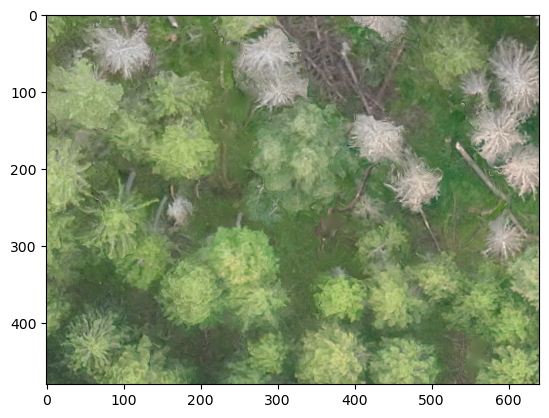

In [ ]:
gdf = gpd.read_file('example_data/R70C21.shp')
im_path = 'example_data/R70C21.tif'

with rio.open(im_path) as im: 
    im_data = im.read()
plt.imshow(im_data.swapaxes(0,2).swapaxes(0,1))
plt.show()

<AxesSubplot:>

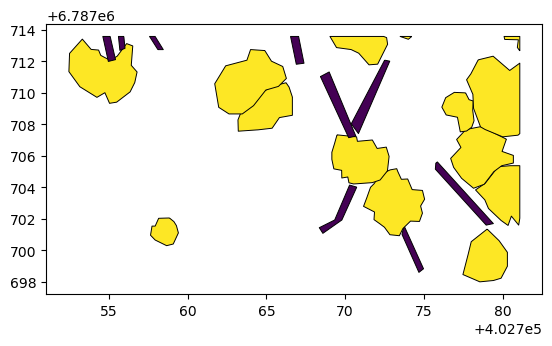

In [ ]:
gdf.plot(column='label', #facecolor='none', 
         edgecolor='black', lw=0.7, cmap='viridis')

<AxesSubplot:>

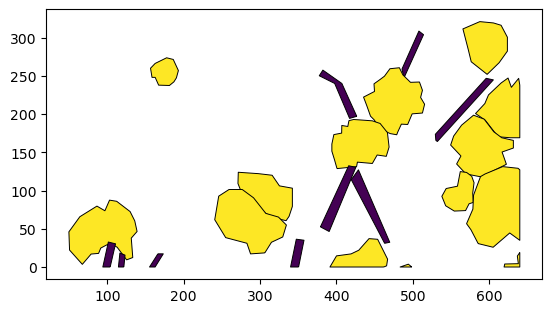

In [ ]:
tfmd_gdf = gdf_to_px(gdf, im_path)
tfmd_gdf.plot(column='label', #facecolor='none', 
              edgecolor='black', lw=0.7, cmap='viridis')

Origin in lower left for this data.

<AxesSubplot:>

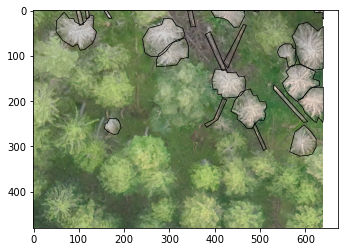

In [ ]:
fig, ax = plt.subplots()
ax.imshow(im_data.swapaxes(0,2).swapaxes(0,1))
tfmd_gdf.plot(ax=ax, column='label', facecolor='none', edgecolor='black', lw=0.7, cmap='viridis')
plt.show()

Overlaid on image coordinates are correct

<AxesSubplot:>

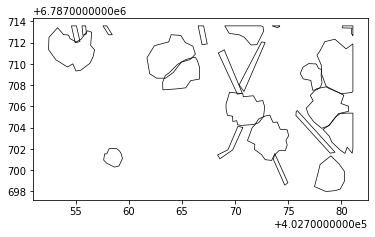

In [ ]:
tfmd_gdf = georegister_px_df(tfmd_gdf, im_path)
tfmd_gdf.plot(column='label', facecolor='none', edgecolor='black', lw=0.7, cmap='viridis')

Backwards transformation works